This Week’s Extra Credit

As before, the probability that an M-seed defeats an N-seed is N/(M+N). But instead of 16 teams in a region, now suppose there are 2k teams, where k is a very large whole number.

The teams are seeded 1 through 2k, and play in a traditional seeded tournament format. That is, in the first round, the sum of opponents’ seeds is 2k+1. If the stronger team always advances, then the sum of opponents’ seeds in the second round is 2k−1+1, and so on. Of course, stronger teams may not always advance, but this convention tells you which seeds can play which other seeds in each round.

For any such region with 2k teams, what is the probability that the 1-seed emerges victorious from the region?

Plan is to create some code to calculate this probability and hope that it converges to something

In [2]:
#from fractions import Fraction
import matplotlib.pyplot as plt
def outcomes(k, level=0, min_seed=1):
    """This function takes k, level, and min_seed, which define where in the tree you are.
    On the downward part of the recursion, it fills out the tree, figuring out who will play against whom.
    On the upward part of the recursion, it calculates the probabilities of each outcome.
    Final result is all the teams along with their probability of emerging victorious"""

    if (level == k):
        # At the leaf of the tree, just return each team with probability 1.
        return {min_seed : 1}
    next_level = level + 1
    min_seed_sum = (2**next_level)+1
    Ao = outcomes(k, next_level, min_seed)
    Bo = outcomes(k, next_level, (min_seed_sum-min_seed))
    result = {}
    for a,pa in Ao.items():
        for b,pb in Bo.items():
            p_a_plays_b = pa * pb
            p_a_wins = (b/(a+b)) * p_a_plays_b
            p_b_wins = (a/(a+b)) * p_a_plays_b
            result[a] = p_a_wins + (result[a] if (a in result) else 0)
            result[b] = p_b_wins + (result[b] if (b in result) else 0)
    
    return result

Now lets try it out

In [3]:
outcomes(1)

{1: 0.6666666666666666, 2: 0.3333333333333333}

Makes sense.

In [4]:
outcomes(2)

{1: 0.56,
 2: 0.23999999999999996,
 3: 0.12571428571428572,
 4: 0.07428571428571429}

Matches hand-calculation.
So, let's proceed and plot the probability of the 1-seed emerging as k varies.

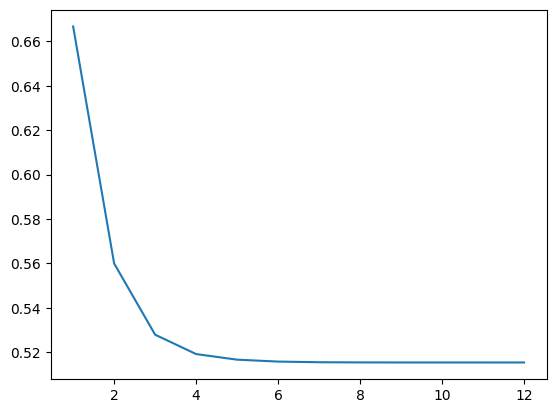

In [5]:
N=12
k_list = range(1,N+1)
p_list = [outcomes(k)[1] for k in k_list]
plt.plot(k_list, p_list)
plt.show()

In [6]:
for p in p_list:
    print(p)

0.6666666666666666
0.56
0.5279401592158794
0.519218355130161
0.5166943992619706
0.515833745724985
0.5155445666341768
0.5154592300379058
0.515437219149804
0.5154322958839175
0.5154314095552367
0.5154313229728595


Is clearly converging to something, though the change in direction from decreasing to increasing is concerning.
But I can't calculate too many more values because the runtime is exploding.
Let's call the final value 0.51543.

------
Revisiting
Let's see if we can get more values with some optimized code that does not calculate all the probabilities that we don't care about (i.e. for seeds other than the seed of interest)

In [100]:
def outcomes_optimized(k, level=0, min_seed=1, seed_of_interest=1, debug=0):
    """Similar to outcomes, but adds seed_of_interest. Final result is just for the seed of interest"""

    if (level == k):
        # At the leaf of the tree, just return each team with probability 1.
        return {min_seed : 1}
    next_level = level + 1
    min_seed_sum = (2**next_level)+1
    Ao = outcomes_optimized(k, next_level, min_seed, seed_of_interest, debug)
    Bo = outcomes_optimized(k, next_level, (min_seed_sum-min_seed), seed_of_interest, debug)
    soi_unavilable = not (seed_of_interest in Ao) and not (seed_of_interest in Bo)
    result = {}
    for a in Ao:
        for b in Bo:
            if (a == seed_of_interest or b == seed_of_interest or soi_unavilable):
                pa = Ao[a]
                pb = Bo[b]
                p_a_plays_b = pa * pb
            if (a == seed_of_interest or soi_unavilable):
                p_a_wins = (b/(a+b)) * p_a_plays_b
                result[a] = p_a_wins + (result[a] if (a in result) else 0)
            if (b == seed_of_interest or soi_unavilable):
                p_b_wins = (a/(a+b)) * p_a_plays_b
                result[b] = p_b_wins + (result[b] if (b in result) else 0)
    
    if (debug):
        if (seed_of_interest in result):
            out_p = result[seed_of_interest]
            in_p = Ao[seed_of_interest] if (seed_of_interest in Ao) else Bo[seed_of_interest]
            stage_p = out_p / in_p
            # x / (soi + x) = stage_p => x = soi * stage_p / (1- stage_p)
            eff_seed = seed_of_interest * stage_p / (1 - stage_p)
            correction = 0 if (level == (k-1)) else 0.5 if (level == (k-2)) else (0.9*(1.5**level))
            expected_seed = (min_seed_sum-seed_of_interest) + correction
            diff = eff_seed - expected_seed
            print(f"level {level}, {seed_of_interest} faces {eff_seed:.5f}. Diff = {diff:.5f}")            
            

    return result

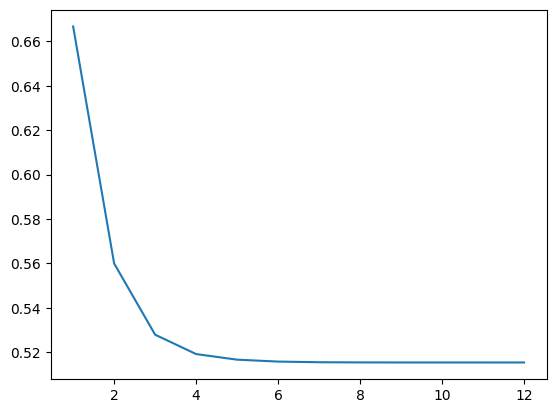

In [101]:
N2=12
k_list_2 = range(1,N2+1)
p_list_opt = [outcomes_optimized(k, seed_of_interest=1)[1] for k in k_list_2]
plt.plot(k_list_2, p_list_opt)
plt.show()

In [102]:
for p in p_list_opt:
    print(p)

0.6666666666666666
0.56
0.5279401592158794
0.519218355130161
0.5166943992619706
0.515833745724985
0.5155445666341768
0.5154592300379058
0.515437219149804
0.5154322958839175
0.5154314095552367
0.5154313229728595


In [103]:
diff_vs_opt = [p_list[i] - p_list_opt[i] for i in range(len(p_list))]
print(diff_vs_opt)


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


-----
This is twice as fast, but still rather slow.

---
New idea.
Conside the 4 seed case, with seeds a < b < c < d
The probability of a winning the first match is d/(a+d)
The probability of a winning the second match is b/(b+c) * c/(a+c)   +  c/(b+c) * b / (a+b)
= bc/(b+c) * [ 1/(a+b) + 1/(a+c)]
The bc/(b+c) term resmbles the harmonic mean (2bc/(b+c)).
So, maybe approximating each match between 2 seed by the harmonic mean of the seeds might be interesting, and easier to calculate.

In [104]:
def outcomes_approx(k, level=0, min_seed=1, seed_of_interest=1, debug=0):
    """Similar to outcomes, but adds seed_of_interest. Final result is just for the seed of interest"""

    if (level == k):
        # At the leaf of the tree, just return each team with probability 1.
        return {min_seed : 1}
    next_level = level + 1
    min_seed_sum = (2**next_level)+1
    Ao = outcomes_approx(k, next_level, min_seed, seed_of_interest, debug)
    Bo = outcomes_approx(k, next_level, (min_seed_sum-min_seed), seed_of_interest, debug)
    soi_unavilable = not (seed_of_interest in Ao) and not (seed_of_interest in Bo)
    result = {}
    for a in Ao:
        for b in Bo:
            if (soi_unavilable):
                hm = 2*a*b/(a+b)
                result[hm] = 1
            else:
                pa = Ao[a]
                pb = Bo[b]
                p_a_plays_b = pa * pb
                if (a == seed_of_interest):
                    p_a_wins = (b/(a+b)) * p_a_plays_b
                    result[a] = p_a_wins
                if (b == seed_of_interest):
                    p_b_wins = (a/(a+b)) * p_a_plays_b
                    result[b] = p_b_wins
    
    if (debug):
        print (Ao, Bo, result)
    return result

In [105]:
# d = outcomes_approx(3,seed_of_interest=1, debug=1)

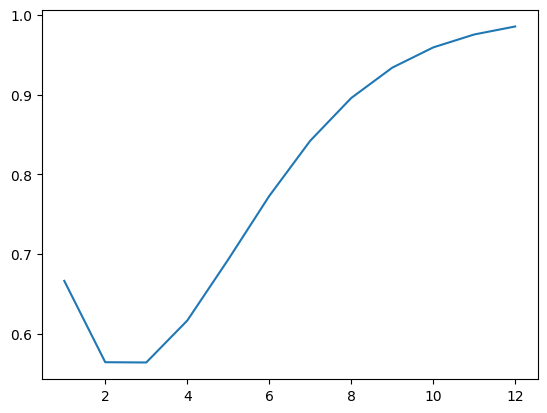

In [106]:
N3=12
k_list_3 = range(1,N3+1)
p_list_approx = [outcomes_approx(k, seed_of_interest=1)[1] for k in k_list_3]
plt.plot(k_list_3, p_list_approx)
plt.show()

In [107]:
for p in p_list_approx:
    print(p)

0.6666666666666666
0.5647058823529413
0.5643738977072311
0.61687509588784
0.6934321534102827
0.7730036160781445
0.8422807106148616
0.8958300349636494
0.9338577844424948
0.9592591725233063
0.9754870414250991
0.9855193000635754


Ouch.
This harmonic mean plan starts out well, but is shortly going in the wrong direction.
Never mind.

---- 
New idea. I want to see the distribution of how the difficulty face by seed 1 varies. So, adding some printouts to the optimized function above.

In [108]:
for i in range(11):
   outcomes_optimized(i,seed_of_interest=1, debug=1)
   print("")


level 0, 1 faces 2.00000. Diff = -0.00000

level 1, 1 faces 4.00000. Diff = 0.00000
level 0, 1 faces 2.33333. Diff = -0.16667

level 2, 1 faces 8.00000. Diff = -0.00000
level 1, 1 faces 4.40000. Diff = -0.10000
level 0, 1 faces 2.68891. Diff = -0.21109

level 3, 1 faces 16.00000. Diff = -0.00000
level 2, 1 faces 8.44444. Diff = -0.05556
level 1, 1 faces 5.00772. Diff = -0.34228
level 0, 1 faces 2.84924. Diff = -0.05076

level 4, 1 faces 32.00000. Diff = 0.00000
level 3, 1 faces 16.47059. Diff = -0.02941
level 2, 1 faces 9.52911. Diff = -0.49589
level 1, 1 faces 5.25462. Diff = -0.09538
level 0, 1 faces 2.89640. Diff = -0.00360

level 5, 1 faces 64.00000. Diff = 0.00000
level 4, 1 faces 32.48485. Diff = -0.01515
level 3, 1 faces 18.49201. Diff = -0.54549
level 2, 1 faces 9.94455. Diff = -0.08045
level 1, 1 faces 5.32339. Diff = -0.02661
level 0, 1 faces 2.90846. Diff = 0.00846

level 6, 1 faces 128.00000. Diff = -0.00000
level 5, 1 faces 64.49231. Diff = -0.00769
level 4, 1 faces 36.37

Hmm, the differences are kinda like a power series, maybe with a factor close 1.5
Trying that out makes the diffs smaller, but nonzero.